# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

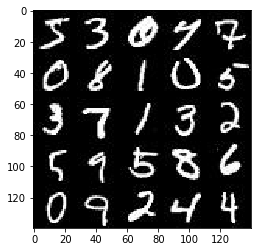

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

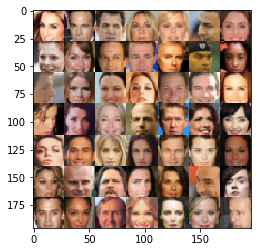

In [3]:
show_n_images = 49

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
    'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_image = tf.placeholder(tf.float32,[None,image_width,image_height,image_channels])
    tensor_Z = tf.placeholder(tf.float32,[None,z_dim])
    learn_rate = tf.placeholder(tf.float32)
    return input_image, tensor_Z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.15
    batchSize,height_i,width_i,deepth_i = images.get_shape().as_list()
    kernal_size = 5
    stridesNum = 2
    with tf.variable_scope('discriminator',reuse=reuse):
        # Input layer is height_i x width_i x deepth_i
        Layer1 = tf.layers.conv2d(images, 64, kernal_size, strides=stridesNum, padding='same')
        relu1 = tf.maximum(alpha * Layer1, Layer1)
        # Now height_i-kernal_size x width_i/2 x 64
        #print(relu1.shape)
        
        Layer2 = tf.layers.conv2d(relu1, 128, kernal_size, strides=stridesNum, padding='same')
        bn2 = tf.layers.batch_normalization(Layer2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # height_i/4 x width_i/4 x 128
        #print(relu2.shape)
        
        Layer3 = tf.layers.conv2d(relu2, 256, kernal_size, strides=stridesNum, padding='same')
        bn3 = tf.layers.batch_normalization(Layer3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # height_i/8 x width_i/8 x 256
        #print(relu3.shape)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        #print(logits.shape)
        outputs = tf.sigmoid(logits)
    return outputs, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        kernal_size = 5
        strideNum = 2
        alpha=0.1
        # First fully connected layer
        gLayer1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        gLayer1 = tf.reshape(gLayer1, (-1,7,7, 256))
        gLayer1 = tf.layers.batch_normalization(gLayer1, training=is_train)
        gLayer1 = tf.maximum(alpha * gLayer1, gLayer1)
        # 5x5x256 now
        #print(gLayer1.shape)        
        gLayer2 = tf.layers.conv2d_transpose(gLayer1, 128, kernal_size, strides=strideNum, padding='same')
        gLayer2 = tf.layers.batch_normalization(gLayer2, training=is_train)
        gLayer2 = tf.maximum(alpha * gLayer2, gLayer2)
        # 14x14x128 now
        #print(gLayer2.shape)        
        gLayer3 = tf.layers.conv2d_transpose(gLayer2, 64, kernal_size, strides=strideNum, padding='same')
        gLayer3 = tf.layers.batch_normalization(gLayer3, training=is_train)
        gLayer3 = tf.maximum(alpha * gLayer3, gLayer3)
        # 14x14x128 now
        #print(gLayer3.shape)        
        # Output layer
        g_logits = tf.layers.conv2d_transpose(gLayer3, out_channel_dim, kernal_size, strides=1, padding='same')
        # 28x28 x out_channel_dim now
        #print(g_logits.shape)        
        g_outputs = tf.tanh(g_logits)
    return g_outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    step_count = 0
    
    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
    input_real, input_z,l_rate = model_inputs(data_shape[2],data_shape[1],data_shape[3], z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt,g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            batch_cnt = 0
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                step_count += 1
                batch_cnt += 1
                # TODO: Train Model
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,l_rate:learning_rate })
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,l_rate:learning_rate })
                
                if step_count % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Batch {}/{}...".format(batch_cnt,data_shape[0]/batch_images.shape[0]),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if step_count % 200 == 0:
                    show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)
        show_generator_output(sess,25,input_z,data_shape[3],data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 20/468.75... Discriminator Loss: 1.0718... Generator Loss: 4.1419
Epoch 1/2... Batch 40/468.75... Discriminator Loss: 0.6502... Generator Loss: 2.0695
Epoch 1/2... Batch 60/468.75... Discriminator Loss: 1.7047... Generator Loss: 2.4762
Epoch 1/2... Batch 80/468.75... Discriminator Loss: 1.3195... Generator Loss: 1.0001
Epoch 1/2... Batch 100/468.75... Discriminator Loss: 1.2858... Generator Loss: 0.9359
Epoch 1/2... Batch 120/468.75... Discriminator Loss: 1.3923... Generator Loss: 1.2655
Epoch 1/2... Batch 140/468.75... Discriminator Loss: 1.5760... Generator Loss: 0.4366
Epoch 1/2... Batch 160/468.75... Discriminator Loss: 1.3755... Generator Loss: 0.9083
Epoch 1/2... Batch 180/468.75... Discriminator Loss: 1.3166... Generator Loss: 1.1339
Epoch 1/2... Batch 200/468.75... Discriminator Loss: 1.3052... Generator Loss: 1.0596


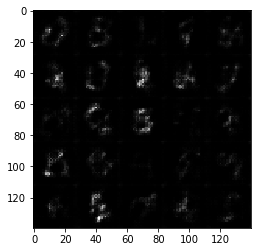

Epoch 1/2... Batch 220/468.75... Discriminator Loss: 1.2757... Generator Loss: 0.9170
Epoch 1/2... Batch 240/468.75... Discriminator Loss: 1.2717... Generator Loss: 0.7664
Epoch 1/2... Batch 260/468.75... Discriminator Loss: 1.3137... Generator Loss: 0.7153
Epoch 1/2... Batch 280/468.75... Discriminator Loss: 1.3068... Generator Loss: 0.8235
Epoch 1/2... Batch 300/468.75... Discriminator Loss: 1.3709... Generator Loss: 0.6692
Epoch 1/2... Batch 320/468.75... Discriminator Loss: 1.3125... Generator Loss: 1.0242
Epoch 1/2... Batch 340/468.75... Discriminator Loss: 1.3788... Generator Loss: 0.8644
Epoch 1/2... Batch 360/468.75... Discriminator Loss: 1.5026... Generator Loss: 0.5974
Epoch 1/2... Batch 380/468.75... Discriminator Loss: 1.3092... Generator Loss: 1.0279
Epoch 1/2... Batch 400/468.75... Discriminator Loss: 1.3741... Generator Loss: 0.9770


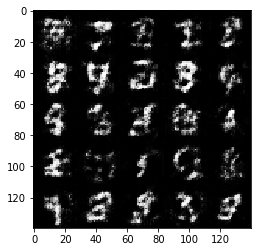

Epoch 1/2... Batch 420/468.75... Discriminator Loss: 1.3166... Generator Loss: 0.6006
Epoch 1/2... Batch 440/468.75... Discriminator Loss: 1.2904... Generator Loss: 0.8840
Epoch 1/2... Batch 460/468.75... Discriminator Loss: 1.3120... Generator Loss: 0.9754
Epoch 2/2... Batch 12/468.75... Discriminator Loss: 1.2969... Generator Loss: 0.8640
Epoch 2/2... Batch 32/468.75... Discriminator Loss: 1.4409... Generator Loss: 0.5859
Epoch 2/2... Batch 52/468.75... Discriminator Loss: 1.3133... Generator Loss: 0.7312
Epoch 2/2... Batch 72/468.75... Discriminator Loss: 1.2564... Generator Loss: 0.7931
Epoch 2/2... Batch 92/468.75... Discriminator Loss: 1.2832... Generator Loss: 1.1319
Epoch 2/2... Batch 112/468.75... Discriminator Loss: 1.3081... Generator Loss: 1.1355
Epoch 2/2... Batch 132/468.75... Discriminator Loss: 1.4077... Generator Loss: 0.6529


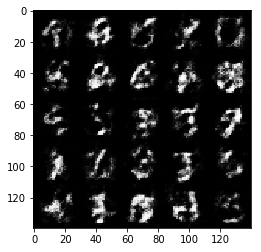

Epoch 2/2... Batch 152/468.75... Discriminator Loss: 1.2375... Generator Loss: 0.9680
Epoch 2/2... Batch 172/468.75... Discriminator Loss: 1.2316... Generator Loss: 0.7962
Epoch 2/2... Batch 192/468.75... Discriminator Loss: 1.4515... Generator Loss: 0.6853
Epoch 2/2... Batch 212/468.75... Discriminator Loss: 1.3049... Generator Loss: 0.7872
Epoch 2/2... Batch 232/468.75... Discriminator Loss: 1.3194... Generator Loss: 0.6889
Epoch 2/2... Batch 252/468.75... Discriminator Loss: 1.3660... Generator Loss: 1.0195
Epoch 2/2... Batch 272/468.75... Discriminator Loss: 1.3048... Generator Loss: 0.9839
Epoch 2/2... Batch 292/468.75... Discriminator Loss: 1.3502... Generator Loss: 0.9377
Epoch 2/2... Batch 312/468.75... Discriminator Loss: 1.3230... Generator Loss: 0.7748
Epoch 2/2... Batch 332/468.75... Discriminator Loss: 1.2805... Generator Loss: 0.9281


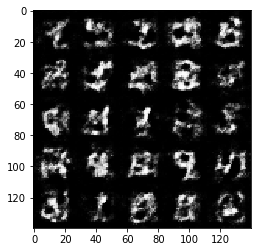

Epoch 2/2... Batch 352/468.75... Discriminator Loss: 1.3540... Generator Loss: 1.1356
Epoch 2/2... Batch 372/468.75... Discriminator Loss: 1.3490... Generator Loss: 1.0944
Epoch 2/2... Batch 392/468.75... Discriminator Loss: 1.3149... Generator Loss: 0.9331
Epoch 2/2... Batch 412/468.75... Discriminator Loss: 1.3266... Generator Loss: 1.1233
Epoch 2/2... Batch 432/468.75... Discriminator Loss: 1.3195... Generator Loss: 1.0039
Epoch 2/2... Batch 452/468.75... Discriminator Loss: 1.2631... Generator Loss: 0.8686


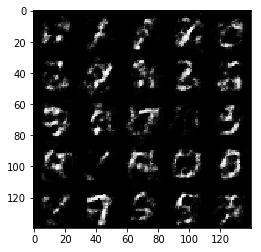

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 20/1582.8046875... Discriminator Loss: 2.9603... Generator Loss: 0.1750
Epoch 1/1... Batch 40/1582.8046875... Discriminator Loss: 1.0358... Generator Loss: 3.0293
Epoch 1/1... Batch 60/1582.8046875... Discriminator Loss: 1.8836... Generator Loss: 0.3031
Epoch 1/1... Batch 80/1582.8046875... Discriminator Loss: 1.4477... Generator Loss: 0.5587
Epoch 1/1... Batch 100/1582.8046875... Discriminator Loss: 1.2397... Generator Loss: 1.6366
Epoch 1/1... Batch 120/1582.8046875... Discriminator Loss: 1.6647... Generator Loss: 0.5747
Epoch 1/1... Batch 140/1582.8046875... Discriminator Loss: 1.6904... Generator Loss: 0.8413
Epoch 1/1... Batch 160/1582.8046875... Discriminator Loss: 1.5832... Generator Loss: 0.5271
Epoch 1/1... Batch 180/1582.8046875... Discriminator Loss: 1.4200... Generator Loss: 0.7627
Epoch 1/1... Batch 200/1582.8046875... Discriminator Loss: 1.4721... Generator Loss: 0.7401


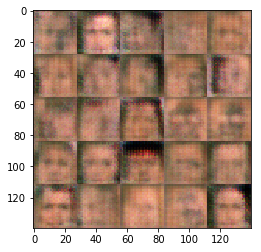

Epoch 1/1... Batch 220/1582.8046875... Discriminator Loss: 1.5406... Generator Loss: 0.8015
Epoch 1/1... Batch 240/1582.8046875... Discriminator Loss: 1.3888... Generator Loss: 0.8637
Epoch 1/1... Batch 260/1582.8046875... Discriminator Loss: 1.4309... Generator Loss: 0.7340
Epoch 1/1... Batch 280/1582.8046875... Discriminator Loss: 1.5714... Generator Loss: 0.7179
Epoch 1/1... Batch 300/1582.8046875... Discriminator Loss: 1.4167... Generator Loss: 0.9219
Epoch 1/1... Batch 320/1582.8046875... Discriminator Loss: 1.4044... Generator Loss: 0.8160
Epoch 1/1... Batch 340/1582.8046875... Discriminator Loss: 1.4208... Generator Loss: 0.7531
Epoch 1/1... Batch 360/1582.8046875... Discriminator Loss: 1.4569... Generator Loss: 0.7456
Epoch 1/1... Batch 380/1582.8046875... Discriminator Loss: 1.3639... Generator Loss: 0.8705
Epoch 1/1... Batch 400/1582.8046875... Discriminator Loss: 1.4237... Generator Loss: 0.8372


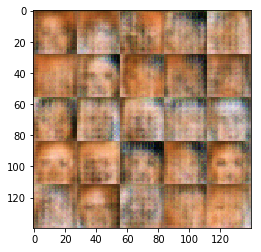

Epoch 1/1... Batch 420/1582.8046875... Discriminator Loss: 1.3947... Generator Loss: 0.7887
Epoch 1/1... Batch 440/1582.8046875... Discriminator Loss: 1.4623... Generator Loss: 0.8643
Epoch 1/1... Batch 460/1582.8046875... Discriminator Loss: 1.4506... Generator Loss: 0.7829
Epoch 1/1... Batch 480/1582.8046875... Discriminator Loss: 1.4838... Generator Loss: 0.7284
Epoch 1/1... Batch 500/1582.8046875... Discriminator Loss: 1.3439... Generator Loss: 0.8549
Epoch 1/1... Batch 520/1582.8046875... Discriminator Loss: 1.4309... Generator Loss: 0.7715
Epoch 1/1... Batch 540/1582.8046875... Discriminator Loss: 1.4135... Generator Loss: 0.7182
Epoch 1/1... Batch 560/1582.8046875... Discriminator Loss: 1.3619... Generator Loss: 0.8472
Epoch 1/1... Batch 580/1582.8046875... Discriminator Loss: 1.4221... Generator Loss: 0.8117
Epoch 1/1... Batch 600/1582.8046875... Discriminator Loss: 1.3765... Generator Loss: 0.7924


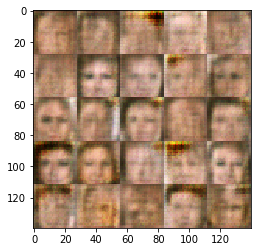

Epoch 1/1... Batch 620/1582.8046875... Discriminator Loss: 1.2984... Generator Loss: 0.8280
Epoch 1/1... Batch 640/1582.8046875... Discriminator Loss: 1.4193... Generator Loss: 0.7760
Epoch 1/1... Batch 660/1582.8046875... Discriminator Loss: 1.3421... Generator Loss: 0.8913
Epoch 1/1... Batch 680/1582.8046875... Discriminator Loss: 1.4337... Generator Loss: 0.8127
Epoch 1/1... Batch 700/1582.8046875... Discriminator Loss: 1.3878... Generator Loss: 0.7950
Epoch 1/1... Batch 720/1582.8046875... Discriminator Loss: 1.3192... Generator Loss: 0.9324
Epoch 1/1... Batch 740/1582.8046875... Discriminator Loss: 1.3552... Generator Loss: 0.8517
Epoch 1/1... Batch 760/1582.8046875... Discriminator Loss: 1.3887... Generator Loss: 0.8567
Epoch 1/1... Batch 780/1582.8046875... Discriminator Loss: 1.4094... Generator Loss: 0.7534
Epoch 1/1... Batch 800/1582.8046875... Discriminator Loss: 1.3669... Generator Loss: 0.7687


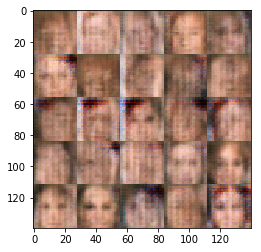

Epoch 1/1... Batch 820/1582.8046875... Discriminator Loss: 1.3820... Generator Loss: 0.8325
Epoch 1/1... Batch 840/1582.8046875... Discriminator Loss: 1.3825... Generator Loss: 0.7780
Epoch 1/1... Batch 860/1582.8046875... Discriminator Loss: 1.4471... Generator Loss: 0.7667
Epoch 1/1... Batch 880/1582.8046875... Discriminator Loss: 1.3854... Generator Loss: 0.7276
Epoch 1/1... Batch 900/1582.8046875... Discriminator Loss: 1.3995... Generator Loss: 0.8179
Epoch 1/1... Batch 920/1582.8046875... Discriminator Loss: 1.3949... Generator Loss: 0.8899
Epoch 1/1... Batch 940/1582.8046875... Discriminator Loss: 1.4183... Generator Loss: 0.7910
Epoch 1/1... Batch 960/1582.8046875... Discriminator Loss: 1.3838... Generator Loss: 0.8179
Epoch 1/1... Batch 980/1582.8046875... Discriminator Loss: 1.4368... Generator Loss: 0.7416
Epoch 1/1... Batch 1000/1582.8046875... Discriminator Loss: 1.4049... Generator Loss: 0.7993


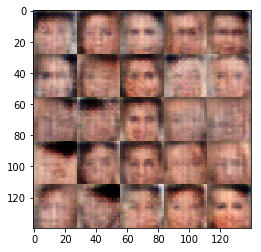

Epoch 1/1... Batch 1020/1582.8046875... Discriminator Loss: 1.3679... Generator Loss: 0.8299
Epoch 1/1... Batch 1040/1582.8046875... Discriminator Loss: 1.4571... Generator Loss: 0.7942
Epoch 1/1... Batch 1060/1582.8046875... Discriminator Loss: 1.3420... Generator Loss: 0.8937
Epoch 1/1... Batch 1080/1582.8046875... Discriminator Loss: 1.3711... Generator Loss: 0.7984
Epoch 1/1... Batch 1100/1582.8046875... Discriminator Loss: 1.3025... Generator Loss: 0.8350
Epoch 1/1... Batch 1120/1582.8046875... Discriminator Loss: 1.3617... Generator Loss: 0.8479
Epoch 1/1... Batch 1140/1582.8046875... Discriminator Loss: 1.3544... Generator Loss: 0.7836
Epoch 1/1... Batch 1160/1582.8046875... Discriminator Loss: 1.3375... Generator Loss: 0.8228
Epoch 1/1... Batch 1180/1582.8046875... Discriminator Loss: 1.3544... Generator Loss: 0.8023
Epoch 1/1... Batch 1200/1582.8046875... Discriminator Loss: 1.3871... Generator Loss: 0.9592


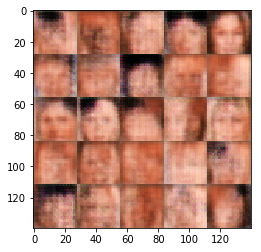

Epoch 1/1... Batch 1220/1582.8046875... Discriminator Loss: 1.4441... Generator Loss: 0.7306
Epoch 1/1... Batch 1240/1582.8046875... Discriminator Loss: 1.3970... Generator Loss: 0.7860
Epoch 1/1... Batch 1260/1582.8046875... Discriminator Loss: 1.4350... Generator Loss: 0.9181
Epoch 1/1... Batch 1280/1582.8046875... Discriminator Loss: 1.3695... Generator Loss: 0.9296
Epoch 1/1... Batch 1300/1582.8046875... Discriminator Loss: 1.4144... Generator Loss: 0.7197
Epoch 1/1... Batch 1320/1582.8046875... Discriminator Loss: 1.4158... Generator Loss: 0.8597
Epoch 1/1... Batch 1340/1582.8046875... Discriminator Loss: 1.3809... Generator Loss: 0.9742
Epoch 1/1... Batch 1360/1582.8046875... Discriminator Loss: 1.4086... Generator Loss: 0.7418
Epoch 1/1... Batch 1380/1582.8046875... Discriminator Loss: 1.4216... Generator Loss: 0.7632
Epoch 1/1... Batch 1400/1582.8046875... Discriminator Loss: 1.3970... Generator Loss: 0.7098


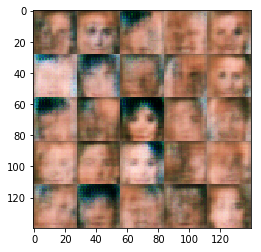

Epoch 1/1... Batch 1420/1582.8046875... Discriminator Loss: 1.3571... Generator Loss: 0.8500
Epoch 1/1... Batch 1440/1582.8046875... Discriminator Loss: 1.3304... Generator Loss: 0.8479
Epoch 1/1... Batch 1460/1582.8046875... Discriminator Loss: 1.3202... Generator Loss: 0.8929
Epoch 1/1... Batch 1480/1582.8046875... Discriminator Loss: 1.3412... Generator Loss: 0.8260
Epoch 1/1... Batch 1500/1582.8046875... Discriminator Loss: 1.3050... Generator Loss: 0.8612
Epoch 1/1... Batch 1520/1582.8046875... Discriminator Loss: 1.4431... Generator Loss: 1.1604
Epoch 1/1... Batch 1540/1582.8046875... Discriminator Loss: 1.3542... Generator Loss: 0.9197
Epoch 1/1... Batch 1560/1582.8046875... Discriminator Loss: 1.4091... Generator Loss: 0.8522
Epoch 1/1... Batch 1580/1582.8046875... Discriminator Loss: 1.3658... Generator Loss: 0.8960


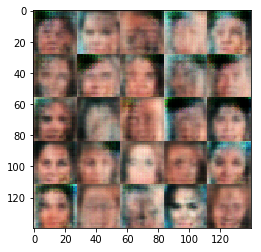

In [13]:
batch_size = 128
z_dim = 300
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.